In [1]:
%matplotlib inline
%load_ext autotime

import matplotlib as mpl
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


time: 17.9 s


In [3]:
import libs.yellowfin as yf

time: 23.9 ms


In [4]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )

time: 1.63 ms


In [5]:
class OptimizerWrapper( keras.optimizers.Optimizer ):
    def __init__( self, optimizer ):
        self.optimizer = optimizer
        self.updates = []
    def get_updates( self, params, constrains, loss ):
        grads = self.optimizer._optimizer.compute_gradients( loss, params, gate_gradients=yf.GATE_OP )
        opt_update = self.optimizer.apply_gradients( grads )
        self.updates.append( opt_update )
        return self.updates
    @property
    def weights( self ):
        raise NotImplementedError
    def get_config( self ):
        raise NotImplementedError
    def from_config( self ):
        raise NotImplementedError

time: 14.7 ms


# load data

In [6]:
from keras.datasets import mnist

( train_x, train_y ), ( test_x, test_y ) = mnist.load_data()
nn_train_x = train_x.astype( float ).reshape( train_x.shape[ 0 ], -1 )
nn_train_x = sk.preprocessing.MinMaxScaler().fit_transform( nn_train_x )
nn_train_y = keras.utils.to_categorical( train_y )
# test_x = test_x.astype( float ).reshape( test_x.shape[ 0 ], -1 )
# test_x = sk.preprocessing.MinMaxScaler().fit_transform( test_x )
# test_y = keras.utils.to_categorical( test_y )
nn_train_x.shape, nn_train_y.shape#, test_x.shape, test_y.shape

((60000, 784), (60000, 10))

time: 966 ms


# parameters

In [7]:
hidden_dim = 128
batch_size = 10000
epochs = 500

time: 1.16 ms


# YellowFin

In [8]:
m1 = keras.models.Sequential()
m1.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.advanced_activations.ELU() )
m1.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.advanced_activations.ELU() )
m1.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.advanced_activations.ELU() )
m1.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'softmax' ) )
m1.compile( loss='categorical_crossentropy', optimizer=OptimizerWrapper( yf.YFOptimizer() ), metrics=[ 'acc' ] )

time: 142 ms


In [9]:
h1 = m1.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 7min 9s


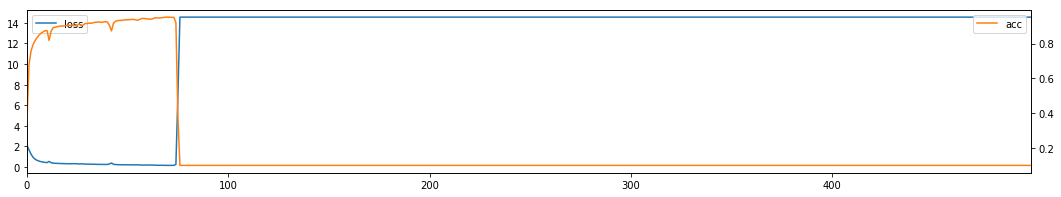

time: 302 ms


In [10]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h1.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h1.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [11]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.097516666666666668

time: 486 ms


In [12]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[   0,    0,    0,    0,    0,    0,    0,    0, 5923,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 6742,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5958,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 6131,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5842,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5421,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5918,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 6265,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5949,    0]])

time: 459 ms


In [13]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5923
          1       0.00      0.00      0.00      6742
          2       0.00      0.00      0.00      5958
          3       0.00      0.00      0.00      6131
          4       0.00      0.00      0.00      5842
          5       0.00      0.00      0.00      5421
          6       0.00      0.00      0.00      5918
          7       0.00      0.00      0.00      6265
          8       0.10      1.00      0.18      5851
          9       0.00      0.00      0.00      5949

avg / total       0.01      0.10      0.02     60000

time: 449 ms


/usr/lib64/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# stochastic gradient descent

In [14]:
m2 = keras.models.Sequential()
m2.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.advanced_activations.ELU() )
m2.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.advanced_activations.ELU() )
m2.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.advanced_activations.ELU() )
m2.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'softmax' ) )
m2.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 64.8 ms


In [15]:
h2 = m2.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 6min 18s


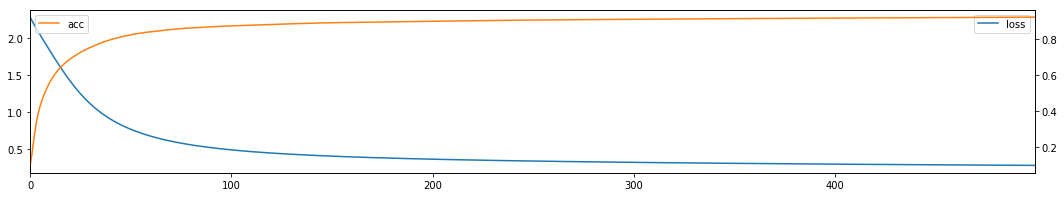

time: 255 ms


In [16]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h2.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h2.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [17]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.91851666666666665

time: 545 ms


In [18]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5722,    0,   19,   13,   12,   42,   43,    8,   59,    5],
       [   1, 6519,   35,   24,    7,   34,    3,   23,   86,   10],
       [  45,   65, 5313,   91,   87,   24,  103,   73,  135,   22],
       [  21,   36,  124, 5437,    4,  244,   25,   70,  116,   54],
       [  10,   30,   30,    3, 5429,    4,   65,    9,   37,  225],
       [  66,   36,   46,  193,   62, 4710,  102,   22,  134,   50],
       [  43,   20,   43,    1,   60,   67, 5651,    1,   32,    0],
       [  26,   48,   85,   23,   67,    7,    1, 5823,   11,  174],
       [  39,  131,   67,  135,   35,  138,   50,   14, 5162,   80],
       [  38,   32,   16,   79,  180,   28,    2,  186,   43, 5345]])

time: 543 ms


In [19]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.95      0.97      0.96      5923
          1       0.94      0.97      0.95      6742
          2       0.92      0.89      0.91      5958
          3       0.91      0.89      0.90      6131
          4       0.91      0.93      0.92      5842
          5       0.89      0.87      0.88      5421
          6       0.93      0.95      0.94      5918
          7       0.93      0.93      0.93      6265
          8       0.89      0.88      0.88      5851
          9       0.90      0.90      0.90      5949

avg / total       0.92      0.92      0.92     60000

time: 513 ms


# Adam

In [20]:
m3 = keras.models.Sequential()
m3.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.advanced_activations.ELU() )
m3.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.advanced_activations.ELU() )
m3.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.advanced_activations.ELU() )
m3.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'softmax' ) )
m3.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 62.8 ms


In [21]:
h3 = m3.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 6min 17s


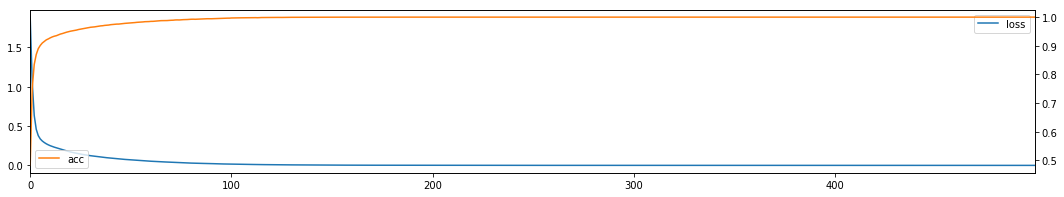

time: 256 ms


In [22]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h3.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h3.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [23]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 592 ms


In [24]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 541 ms


In [25]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 527 ms


# Nesterov Adam

In [26]:
m4 = keras.models.Sequential()
m4.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.advanced_activations.ELU() )
m4.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.advanced_activations.ELU() )
m4.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.advanced_activations.ELU() )
m4.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'softmax' ) )
m4.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[ 'acc' ] )

time: 64.9 ms


In [27]:
h4 = m4.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 6min 16s


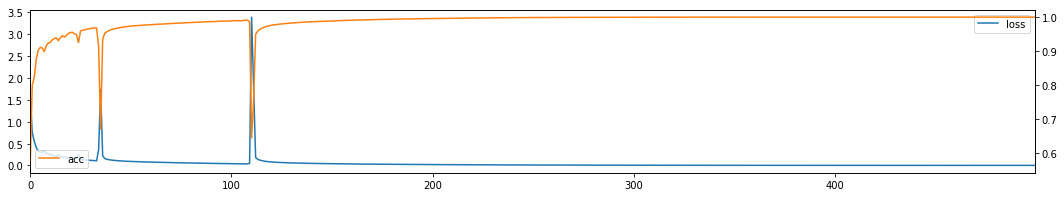

time: 291 ms


In [28]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h4.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h4.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [29]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 588 ms


In [30]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 538 ms


In [31]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 512 ms


# YellowFin (BN)

In [32]:
m5 = keras.models.Sequential()
m5.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.advanced_activations.ELU() )
m5.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.advanced_activations.ELU() )
m5.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.advanced_activations.ELU() )
m5.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.Activation( 'softmax' ) )
m5.compile( loss='categorical_crossentropy', optimizer=OptimizerWrapper( yf.YFOptimizer() ), metrics=[ 'acc' ] )

time: 151 ms


In [33]:
h5 = m5.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 10min 37s


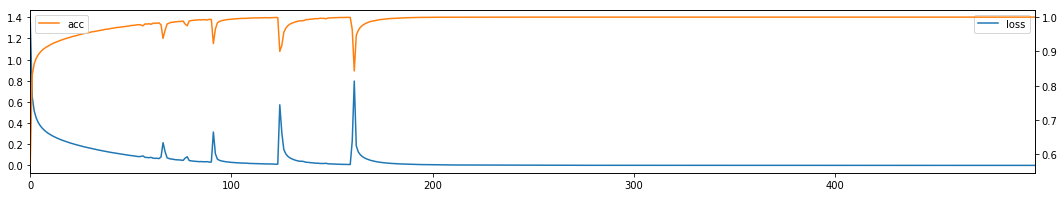

time: 288 ms


In [34]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h5.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h5.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [35]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 882 ms


In [36]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 669 ms


In [37]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 659 ms


# stochastic gradient descent (BN)

In [38]:
m6 = keras.models.Sequential()
m6.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.advanced_activations.ELU() )
m6.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.advanced_activations.ELU() )
m6.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.advanced_activations.ELU() )
m6.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.Activation( 'softmax' ) )
m6.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 160 ms


In [39]:
h6 = m6.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 9min 41s


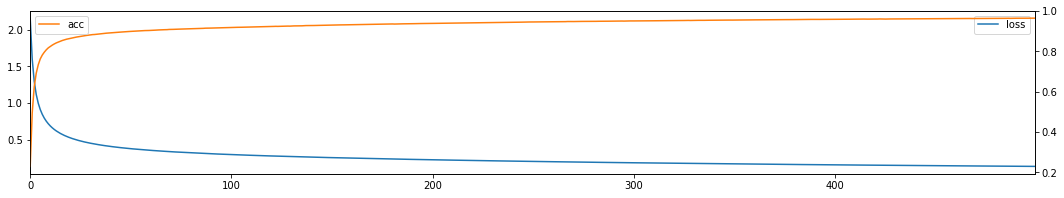

time: 269 ms


In [40]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h6.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h6.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [41]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.96365000000000001

time: 918 ms


In [42]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5820,    1,    9,    8,    8,   10,   32,    5,   23,    7],
       [   1, 6631,   35,   14,    7,   12,    2,   14,   18,    8],
       [  21,   29, 5706,   42,   32,    8,   28,   43,   42,    7],
       [   6,   15,   66, 5805,    4,   86,   11,   45,   60,   33],
       [   6,   14,   20,    6, 5618,    3,   37,   14,   12,  112],
       [  22,   10,   17,   79,   21, 5173,   38,    9,   29,   23],
       [  32,   11,   13,    0,   23,   45, 5778,    1,   15,    0],
       [  14,   32,   37,   12,   36,    4,    1, 6073,    6,   50],
       [  15,   57,   19,   66,   27,   43,   29,   13, 5548,   34],
       [  19,   10,    3,   46,   95,   19,    2,   67,   21, 5667]])

time: 730 ms


In [43]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      5923
          1       0.97      0.98      0.98      6742
          2       0.96      0.96      0.96      5958
          3       0.96      0.95      0.95      6131
          4       0.96      0.96      0.96      5842
          5       0.96      0.95      0.96      5421
          6       0.97      0.98      0.97      5918
          7       0.97      0.97      0.97      6265
          8       0.96      0.95      0.95      5851
          9       0.95      0.95      0.95      5949

avg / total       0.96      0.96      0.96     60000

time: 717 ms


# Nesterov Adam (BN)

In [44]:
m7 = keras.models.Sequential()
m7.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.advanced_activations.ELU() )
m7.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.advanced_activations.ELU() )
m7.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.advanced_activations.ELU() )
m7.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.Activation( 'softmax' ) )
m7.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[ 'acc' ] )

time: 399 ms


In [45]:
h7 = m7.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 9min 35s


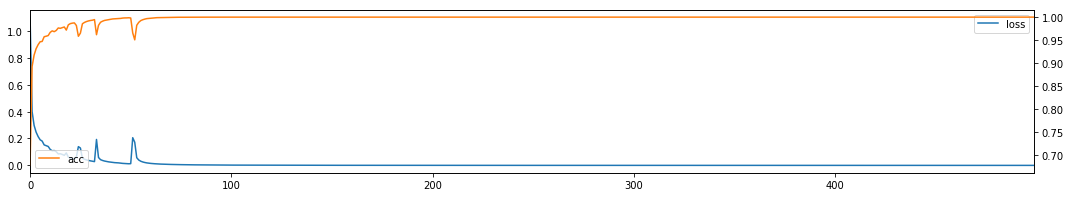

time: 279 ms


In [46]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h7.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h7.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [47]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 985 ms


In [48]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 730 ms


In [49]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 707 ms


# compare

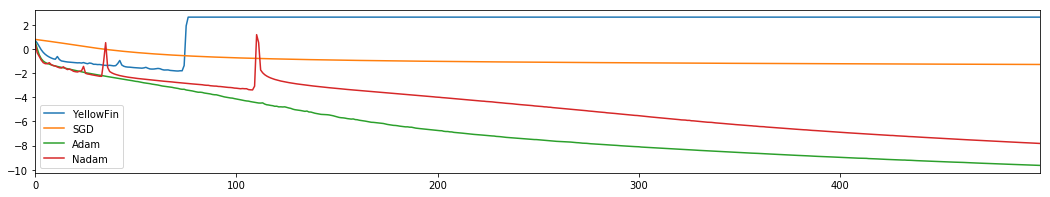

time: 242 ms


In [50]:
_ = pd.Series( np.log( h1.history[ 'loss' ] ), name='YellowFin' ).plot.line( legend=True )
_ = pd.Series( np.log( h2.history[ 'loss' ] ), name='SGD' ).plot.line( legend=True )
_ = pd.Series( np.log( h3.history[ 'loss' ] ), name='Adam' ).plot.line( legend=True )
_ = pd.Series( np.log( h4.history[ 'loss' ] ), name='Nadam' ).plot.line( legend=True )

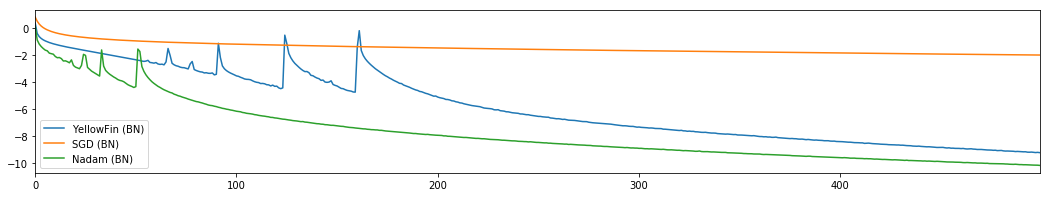

time: 214 ms


In [51]:
_ = pd.Series( np.log( h5.history[ 'loss' ] ), name='YellowFin (BN)' ).plot.line( legend=True )
_ = pd.Series( np.log( h6.history[ 'loss' ] ), name='SGD (BN)' ).plot.line( legend=True )
_ = pd.Series( np.log( h7.history[ 'loss' ] ), name='Nadam (BN)' ).plot.line( legend=True )

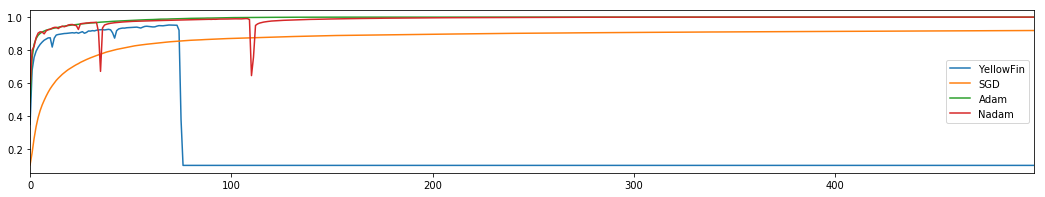

time: 240 ms


In [52]:
_ = pd.Series( h1.history[ 'acc' ], name='YellowFin' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='SGD' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='Adam' ).plot.line( legend=True )
_ = pd.Series( h4.history[ 'acc' ], name='Nadam' ).plot.line( legend=True )

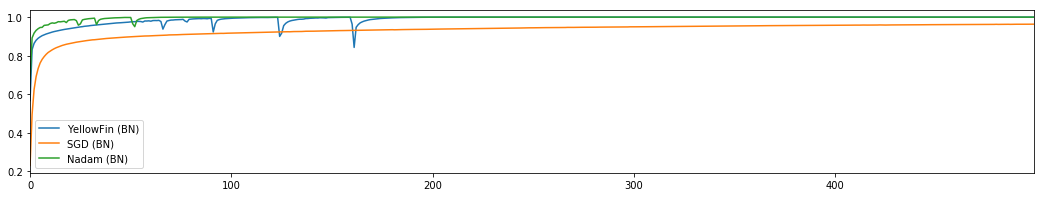

time: 208 ms


In [53]:
_ = pd.Series( h5.history[ 'acc' ], name='YellowFin (BN)' ).plot.line( legend=True )
_ = pd.Series( h6.history[ 'acc' ], name='SGD (BN)' ).plot.line( legend=True )
_ = pd.Series( h7.history[ 'acc' ], name='Nadam (BN)' ).plot.line( legend=True )